# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"

# %cd /content/gdrive/My Drive/Colab Notebooks

In [2]:
#Import all the required libraries
import random
import numpy as np
import pandas as pd
import glob
import pathlib, os
from collections import Counter , OrderedDict
import string
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
import PIL
import PIL.Image
import time

# image processing
from skimage import io
from skimage.transform import rescale, resize

# import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
# sklearn
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4)

from tqdm import tqdm 

Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [3]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
image_count = len(all_imgs)
print(all_imgs[:3])
print("The total images present in the dataset: {}".format(image_count))


['Flickr8K/Images/2201222219_8d656b0633.jpg', 'Flickr8K/Images/3681172959_6674c118d2.jpg', 'Flickr8K/Images/3257107194_f235c8f7ab.jpg']
The total images present in the dataset: 8091


In [4]:
 #Import the dataset and read the text file into a seperate variable
text_file = 'Flickr8K/captions.txt'
def load_doc(filename):
    #your code here
    text = open(filename, 'r', encoding = 'utf-8').read()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [5]:
# all_imgs_t = glob.glob(images + '/*.jpg.npy',recursive=True)
# image_count = len(all_imgs_t)
# print(image_count)

# for i in all_imgs_t:
#     os.remove(i) 

# all_imgs_t = glob.glob(images + '/*.jpg.npy',recursive=True)
# image_count = len(all_imgs_t)
# print(image_count)

0
0


In [6]:
# #Visualise both the images & text present in the dataset
# for i in range(3, 10, 2):
#     plt.figure()
#     img = PIL.Image.open(all_imgs[i])

# #     img = cv2.imread(all_imgs[i])
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
# utility function to clean the caption text
def clean_caption(caption):
    table = str.maketrans('','', string.punctuation)
    desc = caption.split() #create a list of words

    # remove the punctuation from each word
    desc = [word.translate(table) for word in desc]
    
    # remove empty strings and strings like 's and a
    desc = [word.strip() for word in desc if len(word.strip())>1]
    desc = [word.lower() for word in desc if(word.isalpha())] # convert to lower case and pick only alpha numeric 
    return ' '.join(desc)

In [8]:
# utility token to append <start> and <end>
def appendDelimitingTokes(caption):
    return f'<start> {caption} <end>'

In [9]:
# utility function to generate image path
def getImagePaths(s):
    return s.replace('\\', '/')

In [10]:
def getFileName(path):
    return path[len(images)+1:]

In [11]:
all_img_id= list(map(getFileName, all_imgs))#store all the image id here
all_img_vector= list(map(getImagePaths, all_imgs)) #store all the image path here

In [12]:
# utility function to generate mappings of captions to images as a dictionary with image name as index. 
def MapImageCaptions(doc):
    captionDict = dict()
    text_lines = doc.split('\n')
    # remove the heading line and empty lines
    text_lines = [t for t in text_lines[1:] if len(t)>0]
    for line in text_lines:
        dict_index, dict_val = line.split(',', 1)
        if dict_index not in captionDict:
            captionDict[dict_index] = list()
        captionDict[dict_index].append(appendDelimitingTokes(clean_caption(dict_val)))
    return captionDict

In [13]:
captionMappings = MapImageCaptions(doc)
len(captionMappings.items())

8091

In [14]:
annotations= captionMappings.values() #store all the captions here

In [15]:
# create a data frame
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
print(df.shape)
df.head(5)

(8091, 3)


,ID,Path,Captions
0,2201222219_8d656b0633.jpg,Flickr8K/Images/2201222219_8d656b0633.jpg,[A child in a pink dress is climbing up a set ...
1,3681172959_6674c118d2.jpg,Flickr8K/Images/3681172959_6674c118d2.jpg,"[A black dog and a spotted dog are fighting, A..."
2,3257107194_f235c8f7ab.jpg,Flickr8K/Images/3257107194_f235c8f7ab.jpg,[A little girl covered in paint sits in front ...
3,2831656774_36982aafdb.jpg,Flickr8K/Images/2831656774_36982aafdb.jpg,[A man lays on a bench while his dog sits by h...
4,3718892835_a3e74a3417.jpg,Flickr8K/Images/3718892835_a3e74a3417.jpg,[A man in an orange hat starring at something ...


In [16]:
df = (df
 .set_index(['ID','Path'])['Captions']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_2', axis=1)
 .rename(columns={0:'Captions'}))
df.head(5)

,ID,Path,Captions
0,2201222219_8d656b0633.jpg,Flickr8K/Images/2201222219_8d656b0633.jpg,A child in a pink dress is climbing up a set o...
1,2201222219_8d656b0633.jpg,Flickr8K/Images/2201222219_8d656b0633.jpg,A girl going into a wooden building .
2,2201222219_8d656b0633.jpg,Flickr8K/Images/2201222219_8d656b0633.jpg,A little girl climbing into a wooden playhouse .
3,2201222219_8d656b0633.jpg,Flickr8K/Images/2201222219_8d656b0633.jpg,A little girl climbing the stairs to her playh...
4,2201222219_8d656b0633.jpg,Flickr8K/Images/2201222219_8d656b0633.jpg,A little girl in a pink dress going into a woo...


In [17]:
# reference from  https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
def image_desc_plotter():
    npic = 5
    npix = 224
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for image in all_img_vector[10:15]:
        image_id = getFileName(image)
        captions = list(df["Captions"].loc[df["ID"]==image_id].values)
        image_load = load_img(image, target_size=target_size)

        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

In [18]:
# image_desc_plotter()

In [19]:
## returns 2 lists first for clean annotations second for annotations appended with <start> and <end>
def GetAllAnnotations(annotations):
    allcaptions = list()
    dCaptions = list()
    for caption_list in annotations:
        for caption in caption_list:
            caption = clean_caption(caption)
            dCaption = appendDelimitingTokes(caption)
            allcaptions.append(caption)
            dCaptions.append(dCaption)
    return (allcaptions, dCaptions)

In [20]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations, delimitedAnnotations = GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
print("First annotation " + annotations[0])
print("First delimited annotation " + delimitedAnnotations[0])

Total captions present in the dataset: 40455
Total images present in the dataset: 8091
First annotation child in pink dress is climbing up set of stairs in an entry way
First delimited annotation <start> child in pink dress is climbing up set of stairs in an entry way <end>


In [21]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for line in delimitedAnnotations for word in line.split()] #write your code here
# val_count
val_count=Counter(vocabulary)

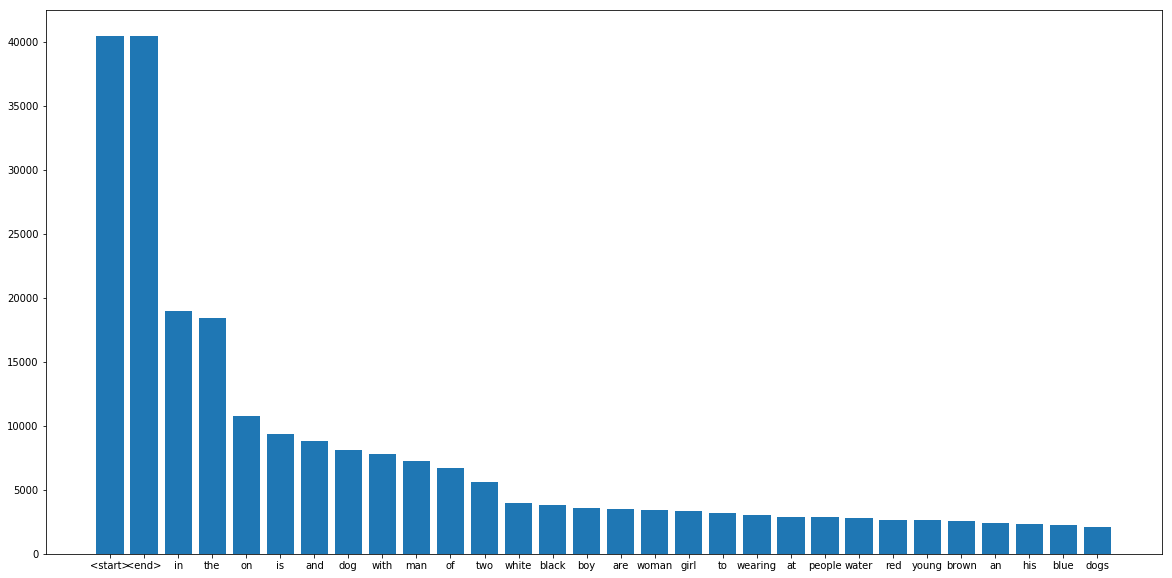

In [22]:
#Visualise the top 30 occuring words in the captions
#write your code here
plt.figure(figsize=(20, 10))
top_words = OrderedDict(val_count.most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [23]:
# create the tokenizer
# create the tokenizer
tokenizer = Tokenizer(num_words = 5001 , oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(delimitedAnnotations)

In [24]:
# Create word-to-index and index-to-word mappings.
# word to index mapping
wordIndex = tokenizer.word_index

In [25]:
#index-to-word mappings
indexToWord = tokenizer.index_word

In [26]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

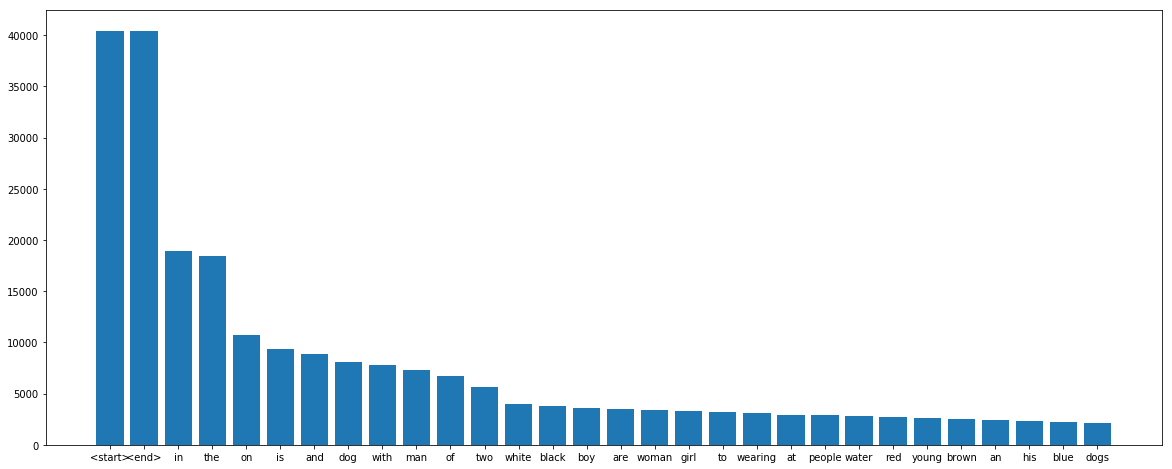

In [27]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
wordCounts = tokenizer.word_counts
plt.figure(figsize=(20, 8))
top_words = OrderedDict(Counter(wordCounts).most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [28]:
text_sequences = tokenizer.texts_to_sequences(delimitedAnnotations)

In [29]:
MaxLength = max(len(d) for d in text_sequences)
MaxLength

34

In [30]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector= pad_sequences(text_sequences, maxlen=MaxLength, padding='post') #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 34)


In [31]:
df['Captions'] = df['Captions'].apply(lambda x:appendDelimitingTokes(clean_caption(x)))

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [32]:
#write your code here
# define the image size
rows = 299
cols = 299

def get_encoded_label(label):
    text_sequences = tokenizer.texts_to_sequences([label])
    return pad_sequences(text_sequences, maxlen=MaxLength, padding='post')[0]

# define a function to resize the images on demand.
def resize_image(image, height=rows, width=cols):
    img = tf.image.decode_jpeg(image, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [height, width])
    return tf.keras.applications.inception_v3.preprocess_input(img)

# define a function to normalize the images on demand between -1 and 1
def normalize_image(image):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
    return normalization_layer(image)
    
# utility function to read image from given path and process it for inception model
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, file_path

def load_image_amit(file_path, cap=None):
    img , _ = process_path(file_path)
    return img, cap

# function to load feature vector saved using imagenet earlier and map it to caption
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [33]:
batch_size=30
BUFFER_SIZE = 1000

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [34]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =  tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [35]:
# write your code to extract features from each image in the dataset
image_vector = sorted(set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(image_vector)
image_dataset = image_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    # we save the features to disk. 
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [36]:
# get data from dataframe based on keys
def getKeyValueLists(keys):
    data = df.loc[df['ID'].isin(keys)]
    return data['Path'].tolist(), data['Captions'].tolist()

In [37]:
train_images, val_images = train_test_split(all_img_id, train_size=0.8, random_state = 42)
len(train_images),len(val_images)

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(6472, 1619)

In [38]:
train_image_idx, train_captions = getKeyValueLists(train_images)
print(len(train_image_idx), len(train_captions))

32360 32360


In [39]:
val_image_idx, val_captions = getKeyValueLists(val_images)
print(len(val_image_idx), len(val_captions))

8095 8095


In [40]:
## tokenize the captions
train_captions =tokenizer.texts_to_sequences( train_captions)
train_captions = pad_sequences(train_captions, maxlen=MaxLength, padding='post')


val_captions =tokenizer.texts_to_sequences( val_captions)
val_captions = pad_sequences(val_captions, maxlen=MaxLength, padding='post')

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [42]:
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          load_image_amit, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [43]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(30, 299, 299, 3)
(30, 34)


## Test data

In [44]:

test_dataset = tf.data.Dataset.from_tensor_slices((val_image_idx, val_captions))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          load_image_amit, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [45]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch_test.shape) #(batch_size, max_len)

(30, 299, 299, 3)
(30, 34)


## Train data from feature vector

In [46]:
#  create a tensor from given data
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [47]:
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [48]:
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [49]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(30, 64, 2048)
(30, 34)


## Test data

In [50]:
#  create a tensor from given data
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_idx, val_captions))

In [51]:
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [52]:
# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size,drop_remainder=True)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [53]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch_test.shape) #(batch_size,40)

(30, 64, 2048)
(30, 34)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [54]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_image_idx) // batch_size
test_num_steps = len(val_image_idx) // batch_size

### Encoder

In [55]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [56]:
encoder=Encoder(embedding_dim)

### Attention model

In [57]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [58]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    # reset_state
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [59]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [60]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
dec_input = tf.cast(dec_input, dtype=tf.float32)

In [61]:
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (30, 64, 256)
Predcitions shape from Decoder: (30, 5001)
Attention weights shape from Decoder: (30, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [62]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [63]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [64]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [65]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#     # restoring the latest checkpoint in checkpoint_path
#     ckpt.restore(ckpt_manager.latest_checkpoint)

In [66]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    # print(hidden.shape)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    # print(dec_input.shape)
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        feature = encoder(img_tensor)
        # print(feature.shape)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, feature, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [67]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
    # passing the features through the decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
      
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id]*batch_size, 1)
 
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [68]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [69]:
EPOCHS = 10
loss_plot = []
test_loss_plot = []
best_test_loss=100
start_epoch = 0

In [70]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / train_num_steps)
    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()
        
    print ('Epoch {} training Loss {:.6f}, test loss : {:.6f}'.format(epoch + 1,total_loss/train_num_steps, best_test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.4231
Epoch 1 Batch 100 Loss 1.6246
Epoch 1 Batch 200 Loss 1.3640
Epoch 1 Batch 300 Loss 1.3207
Epoch 1 Batch 400 Loss 1.4754
Epoch 1 Batch 500 Loss 1.3643
Epoch 1 Batch 600 Loss 1.2487
Epoch 1 Batch 700 Loss 1.2318
Epoch 1 Batch 800 Loss 1.1860
Epoch 1 Batch 900 Loss 1.2646
Epoch 1 Batch 1000 Loss 1.3214
0 (30, 64, 2048) (30, 34)
1 (30, 64, 2048) (30, 34)
2 (30, 64, 2048) (30, 34)
3 (30, 64, 2048) (30, 34)
4 (30, 64, 2048) (30, 34)
5 (30, 64, 2048) (30, 34)
6 (30, 64, 2048) (30, 34)
7 (30, 64, 2048) (30, 34)
8 (30, 64, 2048) (30, 34)
9 (30, 64, 2048) (30, 34)
10 (30, 64, 2048) (30, 34)
11 (30, 64, 2048) (30, 34)
12 (30, 64, 2048) (30, 34)
13 (30, 64, 2048) (30, 34)
14 (30, 64, 2048) (30, 34)
15 (30, 64, 2048) (30, 34)
16 (30, 64, 2048) (30, 34)
17 (30, 64, 2048) (30, 34)
18 (30, 64, 2048) (30, 34)
19 (30, 64, 2048) (30, 34)
20 (30, 64, 2048) (30, 34)
21 (30, 64, 2048) (30, 34)
22 (30, 64, 2048) (30, 34)
23 (30, 64, 2048) (30, 34)
24 (30, 64, 2048) (30, 34)
25 (30

Epoch 2 Batch 1000 Loss 1.2688
0 (30, 64, 2048) (30, 34)
1 (30, 64, 2048) (30, 34)
2 (30, 64, 2048) (30, 34)
3 (30, 64, 2048) (30, 34)
4 (30, 64, 2048) (30, 34)
5 (30, 64, 2048) (30, 34)
6 (30, 64, 2048) (30, 34)
7 (30, 64, 2048) (30, 34)
8 (30, 64, 2048) (30, 34)
9 (30, 64, 2048) (30, 34)
10 (30, 64, 2048) (30, 34)
11 (30, 64, 2048) (30, 34)
12 (30, 64, 2048) (30, 34)
13 (30, 64, 2048) (30, 34)
14 (30, 64, 2048) (30, 34)
15 (30, 64, 2048) (30, 34)
16 (30, 64, 2048) (30, 34)
17 (30, 64, 2048) (30, 34)
18 (30, 64, 2048) (30, 34)
19 (30, 64, 2048) (30, 34)
20 (30, 64, 2048) (30, 34)
21 (30, 64, 2048) (30, 34)
22 (30, 64, 2048) (30, 34)
23 (30, 64, 2048) (30, 34)
24 (30, 64, 2048) (30, 34)
25 (30, 64, 2048) (30, 34)
26 (30, 64, 2048) (30, 34)
27 (30, 64, 2048) (30, 34)
28 (30, 64, 2048) (30, 34)
29 (30, 64, 2048) (30, 34)
30 (30, 64, 2048) (30, 34)
31 (30, 64, 2048) (30, 34)
32 (30, 64, 2048) (30, 34)
33 (30, 64, 2048) (30, 34)
34 (30, 64, 2048) (30, 34)
35 (30, 64, 2048) (30, 34)
36 (30,

10 (30, 64, 2048) (30, 34)
11 (30, 64, 2048) (30, 34)
12 (30, 64, 2048) (30, 34)
13 (30, 64, 2048) (30, 34)
14 (30, 64, 2048) (30, 34)
15 (30, 64, 2048) (30, 34)
16 (30, 64, 2048) (30, 34)
17 (30, 64, 2048) (30, 34)
18 (30, 64, 2048) (30, 34)
19 (30, 64, 2048) (30, 34)
20 (30, 64, 2048) (30, 34)
21 (30, 64, 2048) (30, 34)
22 (30, 64, 2048) (30, 34)
23 (30, 64, 2048) (30, 34)
24 (30, 64, 2048) (30, 34)
25 (30, 64, 2048) (30, 34)
26 (30, 64, 2048) (30, 34)
27 (30, 64, 2048) (30, 34)
28 (30, 64, 2048) (30, 34)
29 (30, 64, 2048) (30, 34)
30 (30, 64, 2048) (30, 34)
31 (30, 64, 2048) (30, 34)
32 (30, 64, 2048) (30, 34)
33 (30, 64, 2048) (30, 34)
34 (30, 64, 2048) (30, 34)
35 (30, 64, 2048) (30, 34)
36 (30, 64, 2048) (30, 34)
37 (30, 64, 2048) (30, 34)
38 (30, 64, 2048) (30, 34)
39 (30, 64, 2048) (30, 34)
40 (30, 64, 2048) (30, 34)
41 (30, 64, 2048) (30, 34)
42 (30, 64, 2048) (30, 34)
43 (30, 64, 2048) (30, 34)
44 (30, 64, 2048) (30, 34)
45 (30, 64, 2048) (30, 34)
46 (30, 64, 2048) (30, 34)
4

24 (30, 64, 2048) (30, 34)
25 (30, 64, 2048) (30, 34)
26 (30, 64, 2048) (30, 34)
27 (30, 64, 2048) (30, 34)
28 (30, 64, 2048) (30, 34)
29 (30, 64, 2048) (30, 34)
30 (30, 64, 2048) (30, 34)
31 (30, 64, 2048) (30, 34)
32 (30, 64, 2048) (30, 34)
33 (30, 64, 2048) (30, 34)
34 (30, 64, 2048) (30, 34)
35 (30, 64, 2048) (30, 34)
36 (30, 64, 2048) (30, 34)
37 (30, 64, 2048) (30, 34)
38 (30, 64, 2048) (30, 34)
39 (30, 64, 2048) (30, 34)
40 (30, 64, 2048) (30, 34)
41 (30, 64, 2048) (30, 34)
42 (30, 64, 2048) (30, 34)
43 (30, 64, 2048) (30, 34)
44 (30, 64, 2048) (30, 34)
45 (30, 64, 2048) (30, 34)
46 (30, 64, 2048) (30, 34)
47 (30, 64, 2048) (30, 34)
48 (30, 64, 2048) (30, 34)
49 (30, 64, 2048) (30, 34)
50 (30, 64, 2048) (30, 34)
51 (30, 64, 2048) (30, 34)
52 (30, 64, 2048) (30, 34)
53 (30, 64, 2048) (30, 34)
54 (30, 64, 2048) (30, 34)
55 (30, 64, 2048) (30, 34)
56 (30, 64, 2048) (30, 34)
57 (30, 64, 2048) (30, 34)
58 (30, 64, 2048) (30, 34)
59 (30, 64, 2048) (30, 34)
60 (30, 64, 2048) (30, 34)
6

38 (30, 64, 2048) (30, 34)
39 (30, 64, 2048) (30, 34)
40 (30, 64, 2048) (30, 34)
41 (30, 64, 2048) (30, 34)
42 (30, 64, 2048) (30, 34)
43 (30, 64, 2048) (30, 34)
44 (30, 64, 2048) (30, 34)
45 (30, 64, 2048) (30, 34)
46 (30, 64, 2048) (30, 34)
47 (30, 64, 2048) (30, 34)
48 (30, 64, 2048) (30, 34)
49 (30, 64, 2048) (30, 34)
50 (30, 64, 2048) (30, 34)
51 (30, 64, 2048) (30, 34)
52 (30, 64, 2048) (30, 34)
53 (30, 64, 2048) (30, 34)
54 (30, 64, 2048) (30, 34)
55 (30, 64, 2048) (30, 34)
56 (30, 64, 2048) (30, 34)
57 (30, 64, 2048) (30, 34)
58 (30, 64, 2048) (30, 34)
59 (30, 64, 2048) (30, 34)
60 (30, 64, 2048) (30, 34)
61 (30, 64, 2048) (30, 34)
62 (30, 64, 2048) (30, 34)
63 (30, 64, 2048) (30, 34)
64 (30, 64, 2048) (30, 34)
65 (30, 64, 2048) (30, 34)
66 (30, 64, 2048) (30, 34)
67 (30, 64, 2048) (30, 34)
68 (30, 64, 2048) (30, 34)
69 (30, 64, 2048) (30, 34)
70 (30, 64, 2048) (30, 34)
71 (30, 64, 2048) (30, 34)
72 (30, 64, 2048) (30, 34)
73 (30, 64, 2048) (30, 34)
74 (30, 64, 2048) (30, 34)
7

52 (30, 64, 2048) (30, 34)
53 (30, 64, 2048) (30, 34)
54 (30, 64, 2048) (30, 34)
55 (30, 64, 2048) (30, 34)
56 (30, 64, 2048) (30, 34)
57 (30, 64, 2048) (30, 34)
58 (30, 64, 2048) (30, 34)
59 (30, 64, 2048) (30, 34)
60 (30, 64, 2048) (30, 34)
61 (30, 64, 2048) (30, 34)
62 (30, 64, 2048) (30, 34)
63 (30, 64, 2048) (30, 34)
64 (30, 64, 2048) (30, 34)
65 (30, 64, 2048) (30, 34)
66 (30, 64, 2048) (30, 34)
67 (30, 64, 2048) (30, 34)
68 (30, 64, 2048) (30, 34)
69 (30, 64, 2048) (30, 34)
70 (30, 64, 2048) (30, 34)
71 (30, 64, 2048) (30, 34)
72 (30, 64, 2048) (30, 34)
73 (30, 64, 2048) (30, 34)
74 (30, 64, 2048) (30, 34)
75 (30, 64, 2048) (30, 34)
76 (30, 64, 2048) (30, 34)
77 (30, 64, 2048) (30, 34)
78 (30, 64, 2048) (30, 34)
79 (30, 64, 2048) (30, 34)
80 (30, 64, 2048) (30, 34)
81 (30, 64, 2048) (30, 34)
82 (30, 64, 2048) (30, 34)
83 (30, 64, 2048) (30, 34)
84 (30, 64, 2048) (30, 34)
85 (30, 64, 2048) (30, 34)
86 (30, 64, 2048) (30, 34)
87 (30, 64, 2048) (30, 34)
88 (30, 64, 2048) (30, 34)
8

66 (30, 64, 2048) (30, 34)
67 (30, 64, 2048) (30, 34)
68 (30, 64, 2048) (30, 34)
69 (30, 64, 2048) (30, 34)
70 (30, 64, 2048) (30, 34)
71 (30, 64, 2048) (30, 34)
72 (30, 64, 2048) (30, 34)
73 (30, 64, 2048) (30, 34)
74 (30, 64, 2048) (30, 34)
75 (30, 64, 2048) (30, 34)
76 (30, 64, 2048) (30, 34)
77 (30, 64, 2048) (30, 34)
78 (30, 64, 2048) (30, 34)
79 (30, 64, 2048) (30, 34)
80 (30, 64, 2048) (30, 34)
81 (30, 64, 2048) (30, 34)
82 (30, 64, 2048) (30, 34)
83 (30, 64, 2048) (30, 34)
84 (30, 64, 2048) (30, 34)
85 (30, 64, 2048) (30, 34)
86 (30, 64, 2048) (30, 34)
87 (30, 64, 2048) (30, 34)
88 (30, 64, 2048) (30, 34)
89 (30, 64, 2048) (30, 34)
90 (30, 64, 2048) (30, 34)
91 (30, 64, 2048) (30, 34)
92 (30, 64, 2048) (30, 34)
93 (30, 64, 2048) (30, 34)
94 (30, 64, 2048) (30, 34)
95 (30, 64, 2048) (30, 34)
96 (30, 64, 2048) (30, 34)
97 (30, 64, 2048) (30, 34)
98 (30, 64, 2048) (30, 34)
99 (30, 64, 2048) (30, 34)
100 (30, 64, 2048) (30, 34)
101 (30, 64, 2048) (30, 34)
102 (30, 64, 2048) (30, 34

80 (30, 64, 2048) (30, 34)
81 (30, 64, 2048) (30, 34)
82 (30, 64, 2048) (30, 34)
83 (30, 64, 2048) (30, 34)
84 (30, 64, 2048) (30, 34)
85 (30, 64, 2048) (30, 34)
86 (30, 64, 2048) (30, 34)
87 (30, 64, 2048) (30, 34)
88 (30, 64, 2048) (30, 34)
89 (30, 64, 2048) (30, 34)
90 (30, 64, 2048) (30, 34)
91 (30, 64, 2048) (30, 34)
92 (30, 64, 2048) (30, 34)
93 (30, 64, 2048) (30, 34)
94 (30, 64, 2048) (30, 34)
95 (30, 64, 2048) (30, 34)
96 (30, 64, 2048) (30, 34)
97 (30, 64, 2048) (30, 34)
98 (30, 64, 2048) (30, 34)
99 (30, 64, 2048) (30, 34)
100 (30, 64, 2048) (30, 34)
101 (30, 64, 2048) (30, 34)
102 (30, 64, 2048) (30, 34)
103 (30, 64, 2048) (30, 34)
104 (30, 64, 2048) (30, 34)
105 (30, 64, 2048) (30, 34)
106 (30, 64, 2048) (30, 34)
107 (30, 64, 2048) (30, 34)
108 (30, 64, 2048) (30, 34)
109 (30, 64, 2048) (30, 34)
110 (30, 64, 2048) (30, 34)
111 (30, 64, 2048) (30, 34)
112 (30, 64, 2048) (30, 34)
113 (30, 64, 2048) (30, 34)
114 (30, 64, 2048) (30, 34)
115 (30, 64, 2048) (30, 34)
116 (30, 64,

93 (30, 64, 2048) (30, 34)
94 (30, 64, 2048) (30, 34)
95 (30, 64, 2048) (30, 34)
96 (30, 64, 2048) (30, 34)
97 (30, 64, 2048) (30, 34)
98 (30, 64, 2048) (30, 34)
99 (30, 64, 2048) (30, 34)
100 (30, 64, 2048) (30, 34)
101 (30, 64, 2048) (30, 34)
102 (30, 64, 2048) (30, 34)
103 (30, 64, 2048) (30, 34)
104 (30, 64, 2048) (30, 34)
105 (30, 64, 2048) (30, 34)
106 (30, 64, 2048) (30, 34)
107 (30, 64, 2048) (30, 34)
108 (30, 64, 2048) (30, 34)
109 (30, 64, 2048) (30, 34)
110 (30, 64, 2048) (30, 34)
111 (30, 64, 2048) (30, 34)
112 (30, 64, 2048) (30, 34)
113 (30, 64, 2048) (30, 34)
114 (30, 64, 2048) (30, 34)
115 (30, 64, 2048) (30, 34)
116 (30, 64, 2048) (30, 34)
117 (30, 64, 2048) (30, 34)
118 (30, 64, 2048) (30, 34)
119 (30, 64, 2048) (30, 34)
120 (30, 64, 2048) (30, 34)
121 (30, 64, 2048) (30, 34)
122 (30, 64, 2048) (30, 34)
123 (30, 64, 2048) (30, 34)
124 (30, 64, 2048) (30, 34)
125 (30, 64, 2048) (30, 34)
126 (30, 64, 2048) (30, 34)
127 (30, 64, 2048) (30, 34)
128 (30, 64, 2048) (30, 34)

106 (30, 64, 2048) (30, 34)
107 (30, 64, 2048) (30, 34)
108 (30, 64, 2048) (30, 34)
109 (30, 64, 2048) (30, 34)
110 (30, 64, 2048) (30, 34)
111 (30, 64, 2048) (30, 34)
112 (30, 64, 2048) (30, 34)
113 (30, 64, 2048) (30, 34)
114 (30, 64, 2048) (30, 34)
115 (30, 64, 2048) (30, 34)
116 (30, 64, 2048) (30, 34)
117 (30, 64, 2048) (30, 34)
118 (30, 64, 2048) (30, 34)
119 (30, 64, 2048) (30, 34)
120 (30, 64, 2048) (30, 34)
121 (30, 64, 2048) (30, 34)
122 (30, 64, 2048) (30, 34)
123 (30, 64, 2048) (30, 34)
124 (30, 64, 2048) (30, 34)
125 (30, 64, 2048) (30, 34)
126 (30, 64, 2048) (30, 34)
127 (30, 64, 2048) (30, 34)
128 (30, 64, 2048) (30, 34)
129 (30, 64, 2048) (30, 34)
130 (30, 64, 2048) (30, 34)
131 (30, 64, 2048) (30, 34)
132 (30, 64, 2048) (30, 34)
133 (30, 64, 2048) (30, 34)
134 (30, 64, 2048) (30, 34)
135 (30, 64, 2048) (30, 34)
136 (30, 64, 2048) (30, 34)
137 (30, 64, 2048) (30, 34)
138 (30, 64, 2048) (30, 34)
139 (30, 64, 2048) (30, 34)
140 (30, 64, 2048) (30, 34)
141 (30, 64, 2048) (

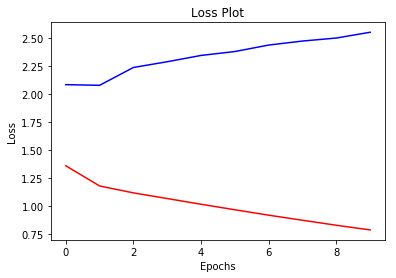

In [78]:
plt.plot(loss_plot, color = 'red')
plt.plot(test_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [79]:
attention_features_shape = 64 #assign from relevant variable above
def evaluate(image):
    attention_plot = np.zeros((MaxLength, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(process_path(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MaxLength):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        predicted_word = tokenizer.index_word[predicted_id]
        result.append(predicted_word)
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [80]:
def beam_evaluate(image, beam_index =7):
    # captions on the validation set
    start = time.time()
    result, attention_plot = evaluate(image)
    #remove "<unk>" in result
    for i in result:
        if i=="<unk>":
            result.remove(i)


    #remove <end> from result         
    result_join = ' '.join(result)
    final_caption = result_join.rsplit(' ', 1)[0]
    print ('Prediction Caption:', final_caption)

    plot_attention(image, result, attention_plot)

    print(f"time took to Predict: {round(time.time()-start)} sec")
                  
    return final_caption



In [91]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(PIL.Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(PIL.Image.fromarray(weights_img).resize((224, 224), PIL.Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [92]:
from nltk.translate.bleu_score import sentence_bleu

In [93]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

BELU score: 1.3464556619841703e-153
Real Caption: man with sunglasses on his head is looking at the woman with white hat and red scarf next to him whilst standing in front of red sports car
Prediction Caption: race car is standing on child in bouncy balls


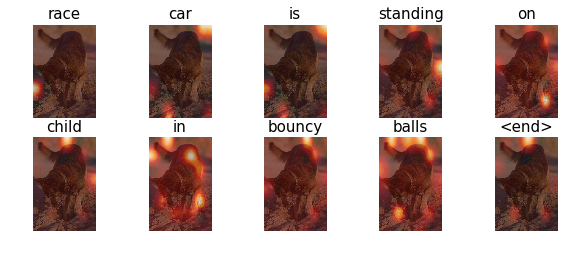

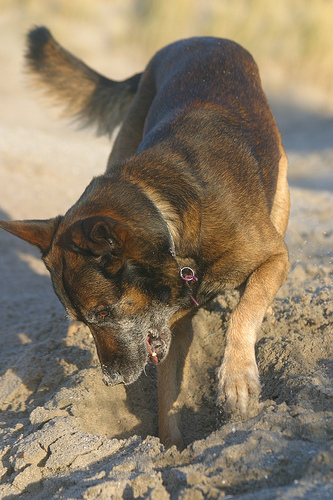

In [94]:
rid = np.random.randint(0, len(val_image_idx))
test_image = val_image_idx[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


PIL.Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)


candidate = captions.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

#print ('Real Caption:', real_caption)
